## Шаг 1. Загрузка библиотек и EDA

### Загрузка датасетов

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import warnings
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from IPython.display import set_matplotlib_formats
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer

set_matplotlib_formats('svg')
warnings.filterwarnings("ignore") 

In [2]:
df = pd.read_csv("IMDB Dataset.csv")

### Визуализация и предварительная предобработка данных

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Как мы видим, столбец sentiment имеет 2 значения: 
- Негатив
- Позитив

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


None

In [5]:
df.isnull().sum() # Проверка значений 

review       0
sentiment    0
dtype: int64

## Шаг 2. Подготовка данных 

In [6]:
labeling = {
    'positive':1, 
    'negative':0
}

df['sentiment'] = df['sentiment'].apply(lambda x : labeling[x])
# Output first ten rows
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


*Теперь мы кодируем позитивные настроения к 1 и отрицательные настроения к 0*

In [7]:
df = df.rename(columns={'review': 'text'})

In [8]:
df.head()

,text,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


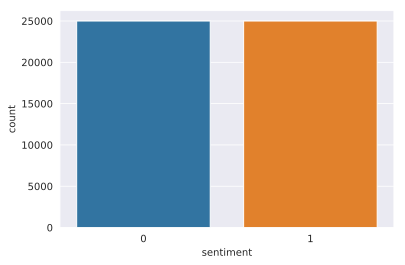

In [9]:
sns.set_style("darkgrid")
sns.countplot(df.sentiment)

## Шаг 3. Удаление стоп-слов

In [10]:
import string # библиотека для работы со строками
import nltk   # Natural Language Toolkit
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/baki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stop = set(stopwords.words('russian'))# загружаем список стоп-слов для русского
punctuation = list(string.punctuation)# знаки препинания
stop.update(punctuation)

In [12]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Удаление квадратных скобок 
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Удаление URL 
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
# Удаление игнорируемых слов из текста 
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
# Удаление зашумленного текста 
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
# Применить функцию 
df['text']=df['text'].apply(denoise_text)


In [13]:
# Лемматизация
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

# Функция, которая принимает предложение и получает его лемматизированную версию.
def lemmatize_text(text):
    token_words=word_tokenize(text) 
# Нужно токенизировать предложение, иначе лемматизация вернет все предложение как есть.
    lemma_sentence=[]
    for word in token_words:
        lemma_sentence.append(lemmatizer.lemmatize(word))
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

# Применить функцию
df['text']=df['text'].apply(lemmatize_text)

[nltk_data] Downloading package punkt to /home/baki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/baki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


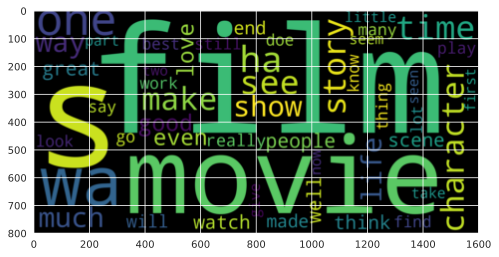

In [14]:
plt.figure(figsize = (8,8)) # Текст, который имеет положительный отзыв
wc = WordCloud(max_words = 50 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.sentiment == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

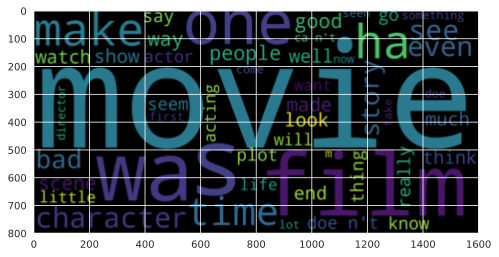

In [15]:
plt.figure(figsize = (8,8)) # Текст который имеет негативнй отзыв
wc = WordCloud(max_words = 50 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.sentiment == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

## Шаг 4. Обучение модели

In [16]:
df = df.sample(frac = 1)#Случайная перетасовка данных

In [17]:
df.reset_index(inplace = True)

In [18]:
df.columns

Index(['index', 'text', 'sentiment'], dtype='object')

In [19]:
df.head()

,index,text,sentiment
0,41592,"The film show relation of the dying mother , a...",0
1,30397,After being forced to sit through some real st...,1
2,35814,This is the worst exercise in middle class pre...,0
3,36184,This movie is a mess . I 'm surprised it even ...,0
4,20366,"The trio are a pleasant , nostalgic journey to...",1


In [20]:
df['text']=df['text'].apply(denoise_text)

### Определение зависимых и независимых переменных¶

In [21]:
x = df["text"]
y = df["sentiment"]

In [22]:
texts = [df.text.iloc[i].split() for i in range(len(df))]

### Теперь разделим набор данных на обучающий и тестовый набор данных

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)
print('\nОбщее количество образцов для обучения :',x_train.shape[0])
print('Общее количество образцов для тестов :',x_test.shape[0])


Общее количество образцов для обучения : 40000
Общее количество образцов для тестов : 10000


# Шаг 5. Извлечение признаков

In [34]:
#вычисляем tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer(max_features = 300)
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

# Топ-50 слов
vectorization.get_feature_names()[:50]

['10',
 'about',
 'acting',
 'action',
 'actor',
 'actually',
 'after',
 'again',
 'all',
 'almost',
 'also',
 'although',
 'always',
 'am',
 'american',
 'an',
 'and',
 'another',
 'any',
 'anyone',
 'anything',
 'are',
 'around',
 'as',
 'at',
 'audience',
 'away',
 'back',
 'bad',
 'be',
 'because',
 'been',
 'before',
 'being',
 'believe',
 'best',
 'better',
 'between',
 'big',
 'bit',
 'book',
 'both',
 'but',
 'by',
 'ca',
 'can',
 'cast',
 'character',
 'child',
 'come']

### Логическая регрессиия

In [35]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(xv_train, y_train)

LogisticRegression()

In [36]:
pred_lr=LR.predict(xv_test)

In [37]:
LR.score(xv_test,y_test)

0.8029

In [38]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      4968
           1       0.80      0.81      0.81      5032

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



## Шаг 6. Тестирование моделей

In [124]:
def output_lable(n):
    if n == 0:
        return "Негативный отзыв"
    elif n == 1:
        return "Положительный отзыв"
    
def manual_testing(text):
    testing_text = {"text":[text]}
    new_def_test = pd.DataFrame(testing_text)
    new_def_test["text"] = new_def_test["text"].apply(denoise_text) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    pred_LR = LR.predict(new_xv_test)
  

    return print("\n\nLR Prediction: {}" .format(output_lable(pred_LR[0])))

In [125]:
text = str(input())
manual_testing(text)

"This was the best sci-fi movie I have ever seen in a long time. It was a mix of military/war combat with alien sci-fi and the two mixed perfectly.I have very very few complaints about the movie, and despite some of the goofs listed, I don't believe they were substantial enough to change anyone's opinion about the movie. I could have done without some of the corny lines, but they did not deter me at all from the movie. Soon after watching the movie for the first time, I bought it and have already watched it four or five times. The combat and action are really exhilarating and Eckhart is a bad ass actor. Great movie, worth the watch. What I enjoyed most about the movie was the amazing effects with the aliens and the nonstop, in your face combat. There was a constant blaze of gunfire and explosions, the perfect Guy movie but even my girlfriend found the movie to be enjoyable(in moderation of course and she probably likes Eckhart). Once again, an amazing movie, watch it now you will not r

In [126]:
text = str(input())
manual_testing(text)


It's been a long time since I've seen a frankly bad movie. It seemed that they simply began to shoot less. Especially if we are talking about the comic books of the Marvel universe, where the Hollywood conveyor a long time ago calculates every scene and every frame to a millimeter of conventional film. However, one of the most anticipated films of the year was able to unpleasantly surprise: in "The Eternals" almost everything is bad. It's a pity, because the project also had almost everything in order to go down in the history of at least the movie comedy. He may, of course, enter, but certainly not as a positive example.


LR Prediction: Негативный отзыв


In [127]:
text = str(input())
manual_testing(text)


3 hours of Hell!!! I had a fight with a guy, hated Leonardo DiCaprio and rubbed in the shower with a washcloth for two hours after watching and all because of this DISGUSTING film. Promoting promiscuity, hypocrisy, drugs, alcohol and extation of all of the above.


LR Prediction: Негативный отзыв


In [128]:
text = str(input())
manual_testing(text)


The film "During a Thunderstorm" (2018). Do you believe in parallel worlds? A wonderful Spanish thriller that is suitable for family viewing


LR Prediction: Положительный отзыв


### Используя модель коэффициентов логистической регрессии, мы можем получить оценки полярности для разных слов.

In [114]:
feats = vectorization.get_feature_names()
vals = LR.coef_
vals = vals.T
vals = vals.reshape(-1)

df_dict = {'Слова':feats,'Полярность':vals}
df_pol = pd.DataFrame(df_dict)

In [116]:
df_pol = df_pol.sort_values(by='Полярность').reset_index(drop=True)

In [120]:
df_pol.head(20)

,Слова,Полярность
0,worst,-13.549133
1,bad,-8.538132
2,nothing,-5.530658
3,script,-4.956284
4,minute,-4.839013
5,instead,-4.671419
6,money,-4.494790
7,even,-3.809002
8,no,-3.738884
9,least,-3.620782


*20 самых негативных слов*

In [123]:
df_pol.tail(20)

,Слова,Полярность
280,seen,2.280985
281,see,2.314563
282,life,2.429678
283,it,2.438162
284,world,2.453758
285,true,2.490230
286,also,2.645559
287,both,2.716651
288,performance,2.747301
289,always,2.932479


*20 самых положительных слов*

# Заключение

### По проделанной работе, можно сделать вывод, что поставленная цель достигнута. Получаемые результаты, соответствуют действительности коментариев. 